In [ ]:
#---- User input-----#
#--------------------#
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
# Experimental values for input
# n=2.46
# n2=1.25*10^-18 m^2/V^2
# wavelength=1.53um
# slab thickness = wavelength
# input amplitude a=1.927*10^8 V/m, time averaged
amp = np.arange(0.007*10**3,1.14*10**3,0.0707*10**3) # amplitude of source
resolution = 90
k = 4.1*10**-6 #4.1*10**-7        # Kerr susceptibility
n=2.46         # index

In [ ]:
def nl_cw(amp,resolution,k,n):
    sz = 10          # size of cell in z direction
    dpml = 1        # PML thickness
    time_set=400         # simulation run time

    #----Continuous Source
    frq_cs=1/1.53          # meep frequency
    cs_width=frq_cs/20          # frequency width

    # frequency range for monitors
    nfreq = 1
    fmin = 1/1.53
    fmax = 1/1.53
    #---source I
    nfreq2 = 100
    fmin2 = 1/1.45
    fmax2 = 1/1.6

    # Geometry
    d_s=1.53# slab thickness
    pos_s=0# slab position
    
    #################################################################
    # Reference simulation (source only)
    #################################################################
    geometry = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=[] ))]
    geometry2 = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=k ))]

    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = mp.PML(dpml)
    default_material = mp.Medium(index=1, chi3=[])

    sources = mp.Source(mp.GaussianSource(frq_cs, fwidth=cs_width), component=mp.Ex,
                        center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)

    sim = mp.Simulation(cell_size=cell,
                        geometry=[],
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)
    trans_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    trans_ref2 = sim.add_flux(0.5 * (fmin2 + fmax2), fmax2 - fmin2, nfreq2,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    #refl_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
    #                        mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))

    #         Define E field monitor
    dx=1/resolution
    dt=0.5*dx
    tm_val_x=[]
    def get_dot(sim):	
        tm_val_x.append(sim.get_array(size=mp.Vector3(), center=mp.Vector3(0,0,0), component=mp.Ex))
    #        #        #        #    
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results
    tm_val_x=np.array(tm_val_x)
    max_ind=np.size(tm_val_x)
    c=3*10**8 # m/s speed of light
    mon_t=[]
    for n in np.arange(0,max_ind,1):
        mon_tmp=(dt+dt*n)*(10**-6/c)*10**15 # s
        mon_t.append(mon_tmp)

    #         Save reference data
    freqs_ref = mp.get_flux_freqs(trans_ref)
    #plt_range_ref=1/np.asarray(freqs_ref)
    box_x1_trans_ref = mp.get_fluxes(trans_ref)
    flux_ref=np.asarray(box_x1_trans_ref)
    #         Save reference data2
    freqs_ref2 = mp.get_flux_freqs(trans_ref2)
    plt_range_ref2=1/np.asarray(freqs_ref2)
    box_x1_trans_ref2 = mp.get_fluxes(trans_ref2)
    flux_ref2=np.asarray(box_x1_trans_ref2)
    #################################################################
    # 1d simulation of a plane wave propagating through a linear slab
    #################################################################
    sim.reset_meep()
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + 4)))

    sim.run(until=time_set)
    #         plot results
    freqs_lin = mp.get_flux_freqs(trans)
    plt_range_lin=1/np.asarray(freqs_lin)
    box_x1_trans_lin = mp.get_fluxes(trans)
    flux_lin=np.asarray(box_x1_trans_lin)
    box_x1_refl_lin = mp.get_fluxes(refl)
    flux_refl_lin=np.asarray(box_x1_refl_lin)

    #################################################################
    # 1d simulation of a plane wave propagating through a Kerr medium
    #################################################################
    sim.reset_meep()
    #geometry = [mp.Block(center=mp.Vector3(0,0,(sz-dpml)/4),size=mp.Vector3(0,0,(sz-dpml)/2), material=mp.Medium(index=n, chi3=k ))]
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry2,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + 4)))

    sim.run(until=time_set)
    #         plot fluxes
    freqs = mp.get_flux_freqs(trans)
    plt_range=1/np.asarray(freqs)
    box_x1_trans = mp.get_fluxes(trans)
    flux=np.asarray(box_x1_trans)
    box_x1_refl = mp.get_fluxes(refl)
    flux_refl=np.asarray(box_x1_refl)

    E_out=np.amax(tm_val_x)/(10**-6)
    T_nl = flux/flux_ref
    R_nl = (-flux_refl+flux_ref)/flux_ref
    A_nl = 1-(-flux_refl+flux_ref)/flux_ref-flux/flux_ref
    T_l = flux_lin/flux_ref
    R_l = (-flux_refl_lin+flux_ref)/flux_ref
    A_l = 1-(-flux_refl_lin+flux_ref)/flux_ref-flux_lin/flux_ref

    figure2=plt.figure(dpi=100)
    ax1=plt.subplot(1, 2, 1)
    plt.plot(mon_t,tm_val_x/(10**-6))
    plt.xlabel('time (fs)')
    plt.ylabel('Ex (V/m)') 
    ax2=plt.subplot(1, 2, 2)
    plt.plot(plt_range_ref2,flux_ref2,'b-',label='T')
    plt.grid(True,which="both",ls="-")
    plt.xlabel('Wavelength, um')
    plt.ylabel('I, W/um^2')
    plt.legend(loc='upper right')
    plt.title('Source intensity')
    plt.tight_layout()

    print(E_out)
    print(T_nl)
    print(R_nl)
    print(A_nl)
    print(T_l)
    print(R_l)
    print(A_l)
    print(plt_range)
    return E_out, plt_range, T_nl, R_nl, A_nl, T_l, R_l, A_l, flux_ref

Meep progress: 252.12222222222223/400.0 = 63.0% done in 4.0s, 2.3s to go
on time step 45459 (time=252.55), 8.79926e-05 s/step
Meep progress: 328.5055555555556/400.0 = 82.1% done in 8.0s, 1.7s to go
on time step 59153 (time=328.628), 0.000292101 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000126123 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000280857 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.51019e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000298977 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
196108454.7859451
[0.96395359]
[0.03604641]
[0.]
[0.94238413]
[0.05761587]
[0.]
[1.53]
12
-----------
Initializing structure...
time for choose_chunkdivision = 6.79493e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000225067 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 214.08333333333334/400.0 = 53.5% done in 4.0s, 3.5s to go
on time step 38592 (time=214.4), 0.000103649 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.17912e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000282049 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.41482e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000432968 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
213777459.18681946
[0.95122926]
[0.04877074]
[0.]
[0.94238413]
[0.05761587]
[0.]
[1.53]
13
-----------
Initializing structure...
time for choose_chunkdivision = 6.81877e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000232935 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 186.66666666666669/400.0 = 46.7% done in 4.0s, 4.6s to go
on time step 33730 (time=187.389), 0.00011859 s/step
Meep progress: 380.4611111111111/400.0 = 95.1% done in 8.0s, 0.4s to go
on time step 68556 (time=380.867), 0.000114858 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 8.01086e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00028801 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.20024e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000277996 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
231446463.58769462
[0.93505179]
[0.06494821]
[0.]
[0.94238413]
[0.05761587]
[0.]
[1.53]
14
-----------
Initializing structure...
time for choose_chunkdivision = 7.39098e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000319004 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 221.61111111111111/400.0 = 55.4% done in 4.0s, 3.2s to go
on time step 40015 (time=222.306), 9.99639e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.31945e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000268936 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000317812 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
249115467.98856923
[0.9161519]
[0.0838481]
[0.]
[0.94238413]
[0.05761587]
[0.]
[1.53]
15
-----------
Initializing structure...
time for choose_chunkdivision = 9.17912e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000242949 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 198.51666666666668/400.0 = 49.6% done in 4.0s, 4.1s to go
on time step 35783 (time=198.794), 0.000111786 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.82285e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000299931 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.70364e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000283003 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
266784472.3894433
[0.89519738]
[0.10480262]
[0.]
[0.94238413]
[0.05761587]
[0.]
[1.53]
16
-----------
Initializing structure...
time for choose_chunkdivision = 9.60827e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000257015 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 172.92222222222222/400.0 = 43.2% done in 4.0s, 5.3s to go
on time step 31292 (time=173.844), 0.00012783 s/step
Meep progress: 385.32222222222225/400.0 = 96.3% done in 8.0s, 0.3s to go
on time step 69358 (time=385.322), 0.000105089 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.41346e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000295877 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.01222e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000286102 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
284453476.7903182
[0.87275004]
[0.12724996]
[0.]
[0.94238413]
[0.05761587]
[0.]
[1.53]


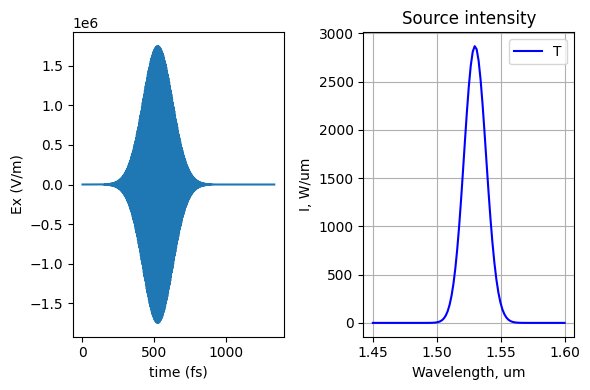

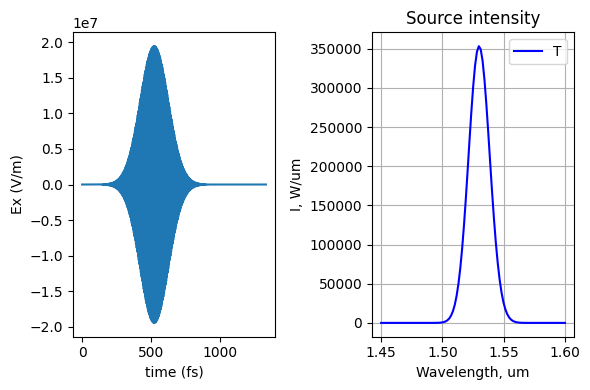

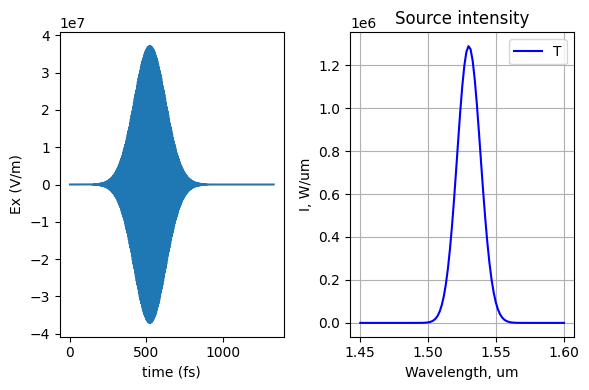

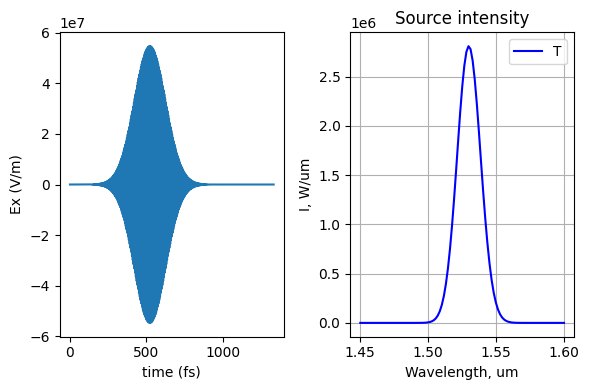

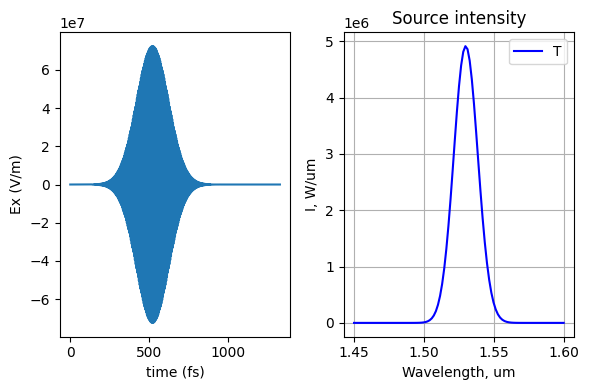

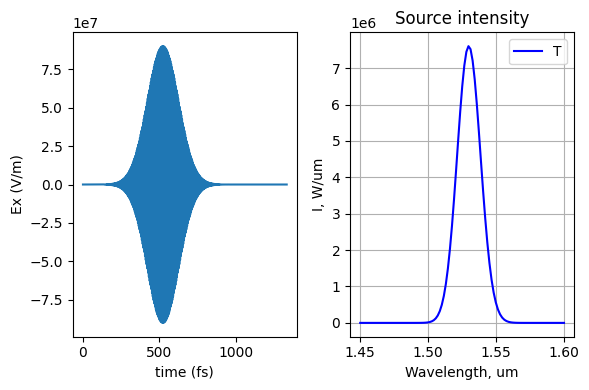

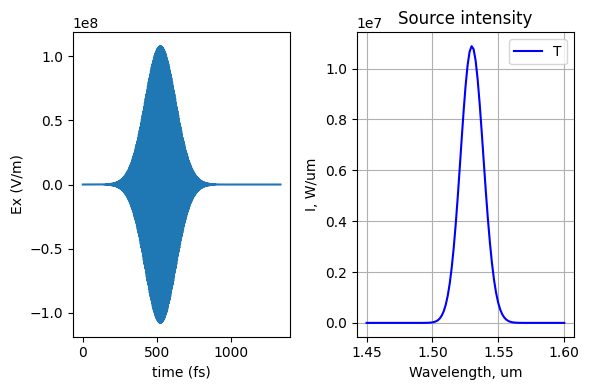

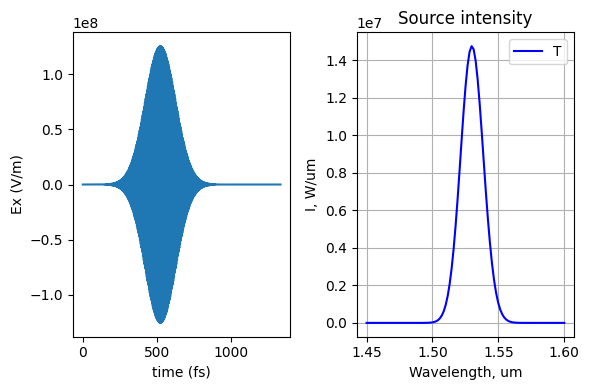

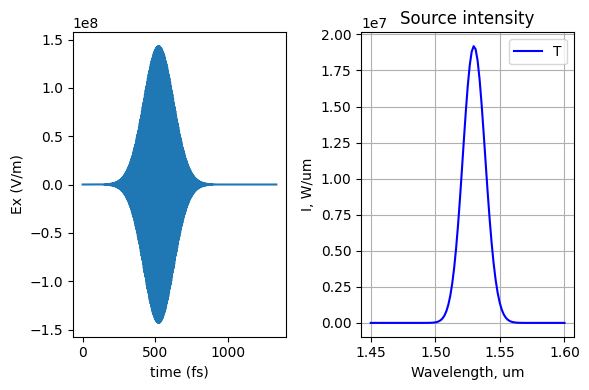

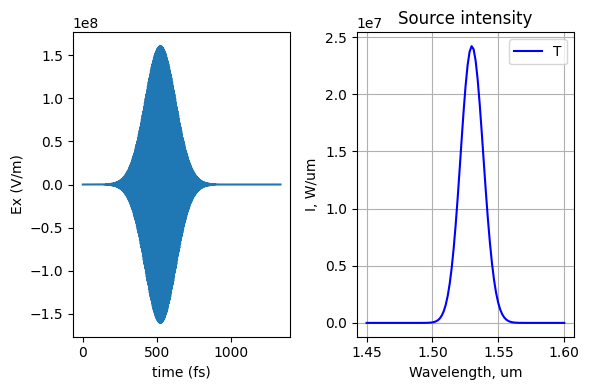

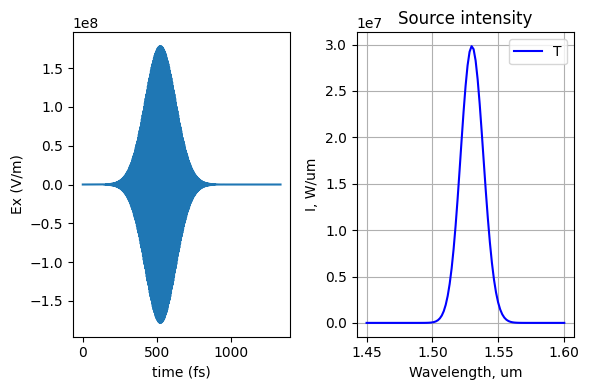

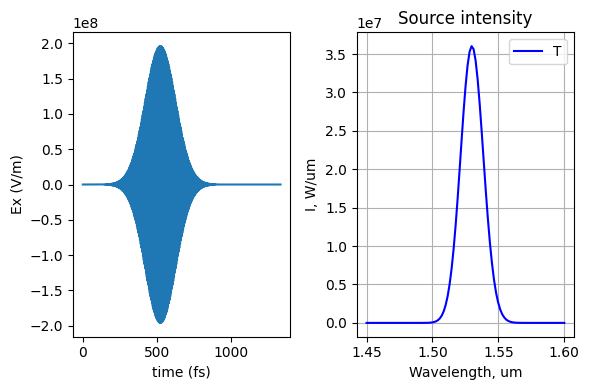

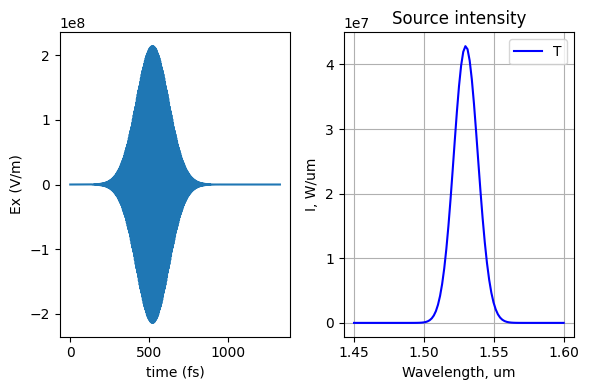

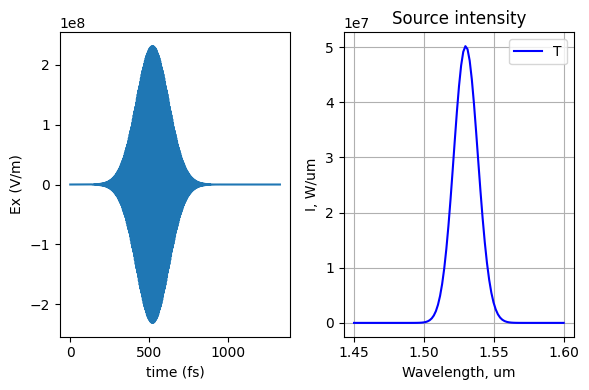

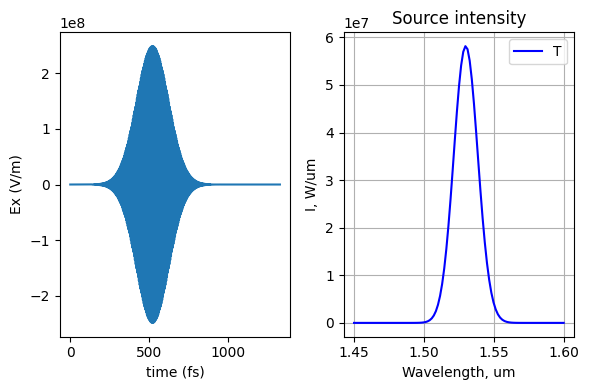

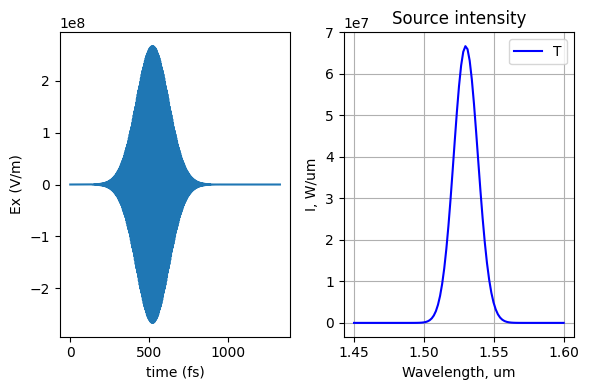

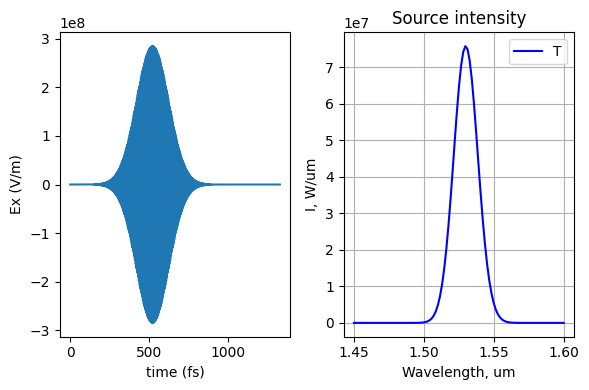

In [3]:
T_nl = np.empty(np.size(amp))
R_nl= np.empty(np.size(amp))
A_nl= np.empty(np.size(amp))
T_l= np.empty(np.size(amp))
R_l= np.empty(np.size(amp))
A_l= np.empty(np.size(amp))
E_out=np.empty(np.size(amp))
flux_ref = np.empty(np.size(amp))
for j in range(np.size(amp)):
  print(j)
  E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j], flux_ref[j] = nl_cw(amp[j],resolution,k,n)

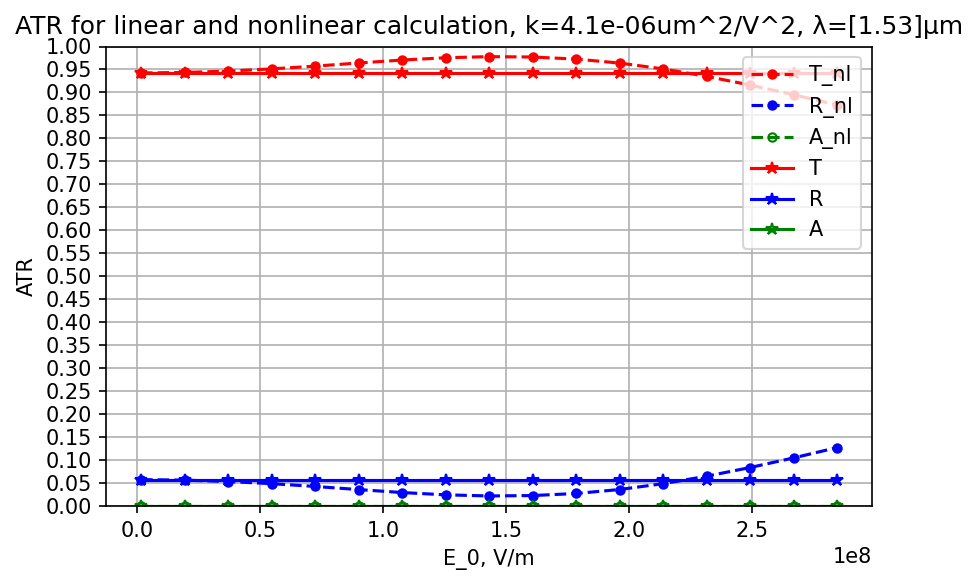

In [4]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out,T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out,R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out,A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out,T_l,'r*-',label='T')
plt.plot(E_out,R_l,'b*-',label='R')
plt.plot(E_out,A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
#plt.xticks([0.2*10**8,0.4*10**8,0.6*10**8,0.8*10**8,1*10**8,1.2*10**8,1.2*10**8,1.4*10**8,1.6*10**8,1.8*10**8,2*10**8,2.2*10**8])
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
#plt.xlim([0.1*10**8,2.4*10**8])
plt.xlabel('E_0, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_E0.txt', (E_out,T_nl,R_nl,A_nl), delimiter=',')

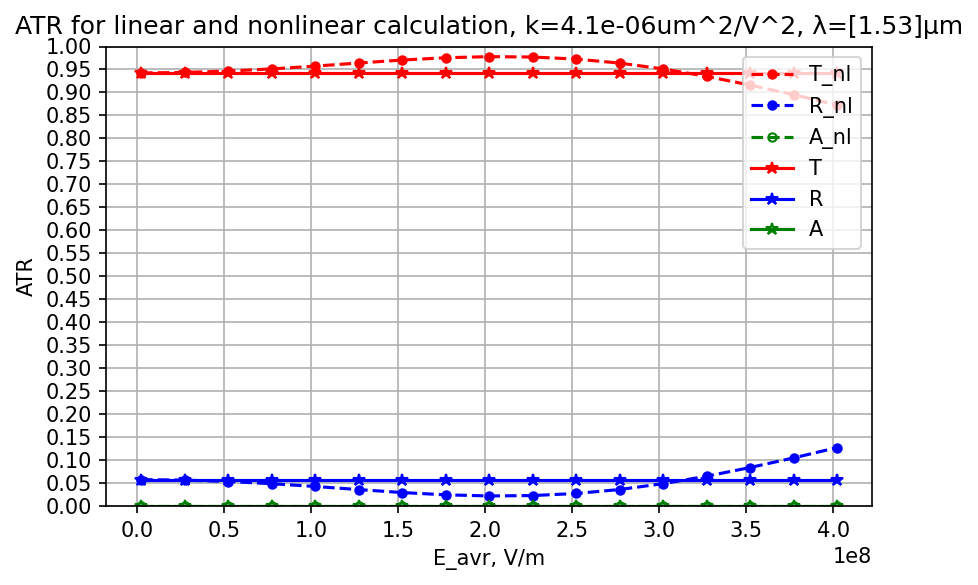

In [5]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out*np.sqrt(2),T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out*np.sqrt(2),T_l,'r*-',label='T')
plt.plot(E_out*np.sqrt(2),R_l,'b*-',label='R')
plt.plot(E_out*np.sqrt(2),A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
plt.xlabel('E_avr, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_Eav.txt', (E_out*np.sqrt(2),T_nl,R_nl,A_nl), delimiter=',')

No handles with labels found to put in legend.


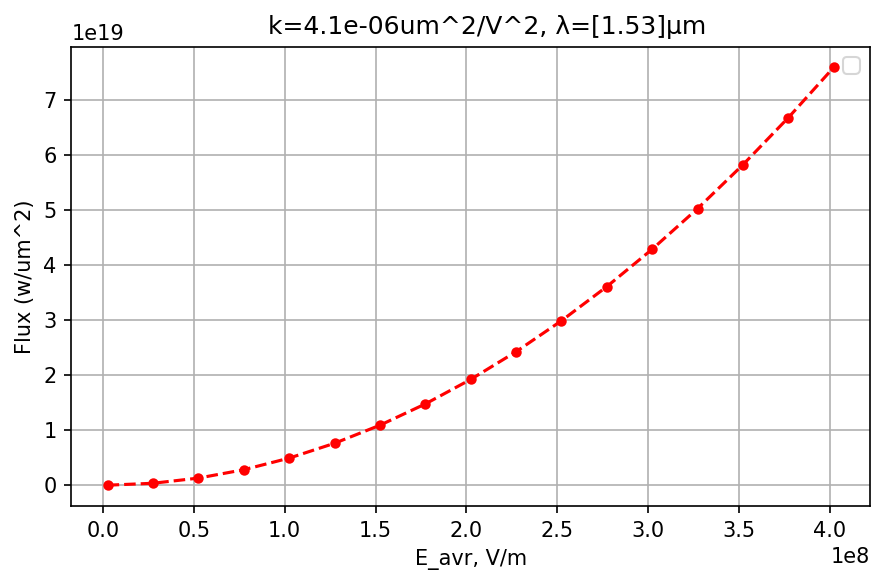

In [7]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out*np.sqrt(2),flux_ref*10**12,'ro--',markersize=4)
plt.grid(True,which="both",ls="-")
plt.xlabel('E_avr, V/m')
plt.ylabel('Flux (w/um^2)')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.title('    k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()